# Laplace Likningen og Iterative Metoder

### FY1003 Elektrisitet og Magnetisme - Numerisk Øving 2

En av de mest sentrale likningene i elektromagnetismen er Laplace likningen, $\nabla^2 V(x,y) = 0$, som beskriver det elektriske felt i vakuum. Denne øvingen handler om å løse Laplace likningen i 2 dimensjoner ved å bruke tre *iterative* metoder, Jacobi metoden,  Gauss-Seidel metoden, og SOR (Successive Over-Relaxation), samt å sammenlikne disse tre metodene. Det forventes kjennskap til numerisk derivasjon, samt bruk og plotting av 2-dimensjonale arrays.

### Oppgave 1: Iterative Metoder

En av de enklere systemene vi kan se på er en kvadratisk boks med lengde, $L$, hvor potensialet på den ene siden er holdt konstant, $V = V_0$, og den motsatte siden er jordet. I denne oppgaven velger vi periodiske grensebetingelser for de to gjenstående sidene, men det er også vanlig å la disse være jordet. For å finne potensialet inne i boksen må man dermed finne en løsning til Laplace likningen, $\nabla^2 V(x,y) = 0$, som oppfyller grensebetingelsene 

- $V(0,y) = V_0$,
- $V(L, y) = 0$,
- $V(x,0) = V(x,L)$.

Dette er en andreordens homogen partiell differensiallikning, og med de gitte grensebetingelsene er det garantert at det eksisterer en unik løsning inne i boksen.

Vi kan diskretisere systemet vårt ved å dele inn den kvadratiske boksen ved hjelp av et $N\times N$ (numerisk) kvadratisk gitter, der hvert punkt på gitteret gis en index $(i,j)$. Vi beskriver koordinater i gitteret ved $(x_i,y_j)$, for $i,j = 1,2,...,N$. På det diskret gitteret blir en gradient omgjort til en endelig forskjell (finite difference). For andre ordens deriverte har vi (for x-retning)

$$
\frac{\partial^2 V}{\partial x^2} = \frac{V(x_{i-1},y_j) - 2V(x_i, y_j) + V(x_{i+1},y_j)}{(\Delta x)^2}
$$

Setter vi dette inn i Laplace ligning, ender vi opp med:

\begin{equation}
0 = \frac{V(x_{i-1},y_j) - 2V(x_i, y_j) + V(x_{i+1},y_j)}{(\Delta x)^2} + \frac{V(x_i,y_{j-1}) - 2V(x_i, y_j) + V(x_i,y_{j+1})}{(\Delta y)^2}
\end{equation}


Hvis vi setter $\Delta x = \Delta y$ får vi
\begin{equation}
V(x_i, y_j) = \frac{1}{4}\big[ V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1})\big]
\end{equation}
For å løse Laplace's ligning må vi altså løse denne ligningen for alle punkter på gitteret for gitte grensebetingelser. Vi skal nå studere tre itterative metoder for å løse den. 

I dette enkle tilfellet er den analytiske løsningen kjent, nemlig $V(x,y) = 1-x/L$ 

--------------

### Oppgave 1:

Den første metoden vi skal se på er Jacobi-metoden. Både Jacobi- og Gauss-Seidel metodene er i prinsippet for å løse matriselikninger av formen $A\vec{x} = \vec{b}$, men de kan omformuleres til å løse problemer som dette også (eller kanskje det vil være mer korrekt å si at dette problemet kan omformuleres til et matriseproblem). Jacobi-metoden er av de enkleste iterative metodene, og er utgangspunktet for Gauss-Seidel og SOR. 

Idéen bak iterative metoder er at man 'gjetter' en løsning, $V^{(0)}$, og ut fra metoden genererer en følge med approksimasjoner, $(V^{(\text{k})})$, som (forhåpentligvis) konvergerer mot riktig løsning. For Laplace likingen vil Jacobi-metoden gi følgende rekursjonsformel

\begin{equation}
V^{(\text{k}+1)}(x_i, y_j)= \frac{1}{4}\big[ V^{(\text{k})}(x_{i-1},y_j) + V^{(\text{k})}(x_{i+1},y_j) + V^{(\text{k})}(x_i,y_{j-1}) + V^{(\text{k})}(x_i,y_{j+1})\big]\text{.}
\end{equation}

$\textbf{a)}$ For en $40 \times 40$ grid, implementer Jacobi metoden på problemet ovenfor og iterer til $\vert \vert V^{(\text{k})}-V\vert \vert < 10^{-1}$ ved å bruke $\texttt{np.linalg.norm}$, der $V$ er den analytiske løsningen, $V = V(x,y) = 1-x/L$. Print antall steg og kjøretid før toleransen er oppnådd, og plot det resulterende potensialet som en heatmap. Merk at med periodiske grensebetingelser så må den første og siste raden håndteres separat fra de andre.

Iteration number 500, the error is 7.90
Iteration number 1000, the error is 3.51
Iteration number 1500, the error is 1.56
Iteration number 2000, the error is 0.69
Iteration number 2500, the error is 0.31
Iteration number 3000, the error is 0.14
Reaching a tolerance of 0.1 took 6.210 seconds and required 3193 steps.


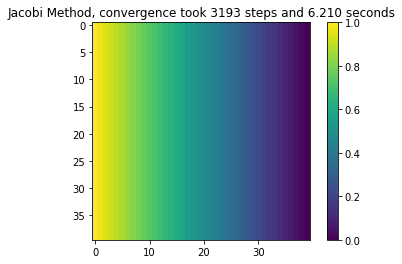

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

N = 40 # Number of discrete grid points on each axis
tol = 1e-1 # Global error tolerance of iterative methods

# Create meshgrids for x- and y- coordinates
x = y = np.linspace(-1, 1, N)
xv, yv = np.meshgrid(x, -y)

# Generate zero matrix with constant potential in first column for our initial guess
V_0 = np.zeros((N,N))
V_0[:, 0] = 1

# Analytical solution for model problem
V_solution = np.zeros((N,N))
for i in np.arange(N):
    V_solution[:, i] = 1 - 1.0*i/(N-1)


# Function to perform Jacobi method
# Input: V_0 = initial guess; V_solution = analytical solution; N = number of discrete points; tol = global error tolerance
# Outputs: Result potential; number of steps required for convergence; time required for convergence
def Jacobi(V_0, V_solution, N, tol):
    
    start_time = time.time() # Initial time to measure runtime
    steps = 1   # Counts number of iterations
    V_old = V_0 # Creates variable for the 'old' array
    
    # Creates a variable for the 'new' array. The reason why a copy is made, rather just setting V_new = V_old
    # is that if V_old = V_new = V_0, then any changes made to V_new will be made to V_old inside the function. 
    # V_0 remains unchanged as it is a global variable.
    V_new = np.copy(V_0)
    
    # Makes the first Jacobi iteration, this is done outside the loop below to avoid the norm being zero
    for j in np.arange(1, N-1):
        # First row handled separately due to periodic BCs
        V_new[0, j] = (V_old[1, j] + V_old[N-1, j] + V_old[0, j+1] + V_old[0, j-1]) / 4.0
        
        # Second to second-to-last rows
        for i in np.arange(1, N-1):
            V_new[i, j] = (V_old[i+1, j] + V_old[i-1, j] + V_old[i, j+1] + V_old[i, j-1]) / 4.0
            
        # Last row handled separately due to periodic BCs
        V_new[N-1, j] = (V_old[0, j] + V_old[N-2, j] + V_old[0, j+1] + V_old[0, j-1]) / 4.0
            
    # Main iteration loop. This will keep iterating until the norm reaches the desired tolerance
    while np.linalg.norm(V_new - V_solution) > tol:
        V_old = np.copy(V_new)
        for j in np.arange(1, N-1):
            # First row handled separately due to periodic BCs
            V_new[0, j] = (V_old[1, j] + V_old[N-1, j] + V_old[0, j+1] + V_old[0, j-1]) / 4.0
            
            # Second to second-to-last rows
            for i in np.arange(1, N-1):
                V_new[i, j] = (V_old[i+1, j] + V_old[i-1, j] + V_old[i, j+1] + V_old[i, j-1]) / 4.0
                
            # Last row handled separately due to periodic BCs
            V_new[N-1, j] = (V_old[0, j] + V_old[N-2, j] + V_old[0, j+1] + V_old[0, j-1]) / 4.0
        steps += 1
        
        # Prints every 500 steps in order to keep track of progress
        if steps%500 == 0:
            print('Iteration number %d, the error is %.2f' %(steps, np.linalg.norm(V_new - V_solution)))
          
    print ('Reaching a tolerance of %.1f took %.3f seconds and required %d steps.' %(tol, time.time() - start_time, steps))
    return V_new, steps, time.time() - start_time

# Calls the Jacobi-function, and unpacks each returned variable into its own variable
Jacob, Jacobsteps, Jacobtime = Jacobi(V_0, V_solution, N, tol)

# Plots result from Jacobi method
plt.imshow(Jacob)
cb = plt.colorbar()
plt.title(r'Jacobi Method, convergence took %d steps and %.3f seconds' %(Jacobsteps, Jacobtime))
plt.show()

---------

Gauss-Seidel metoden er nesten helt identisk Jacobi metoden, men er som regel et bedre valg siden den bruker mindre minne og vil ofte konvergere raskere. Forskjellen mellom de to metodene er at i Gauss-Seidel bruker man kun én array for $V$ og bruker de oppdaterte verdiene etterhvert som de blir beregnet i *samme* iterasjon, mens i Jacobi bruker man kun de gamle verdiene og trenger derfor to arrays for å lagre $V$, nemlig den 'gamle' $V^{(\text{k})}$ og den 'nye' $V^{(\text{k}+1)}$. Dette gir rekursjonsformelen

\begin{equation}
V^{(\text{k}+1)}(x_i, y_j)= \frac{1}{4}\big[ V^{(\text{k}+1)}(x_{i-1},y_j) + V^{(\text{k})}(x_{i+1},y_j) + V^{(\text{k}+1)}(x_i,y_{j-1}) + V^{(\text{k})}(x_i,y_{j+1})\big]\text{,}
\end{equation}

antatt at algoritmen går gjennom radene før kolonnene.

$\textbf{b)}$ For $i,j \in [0, 100]$, implementer Gauss-Seidel metoden på problemet ovenfor og iterer til $\vert \vert V^{(\text{k}+1)}-V^{(\text{k})}\vert \vert < 10^{-4}$ (dette betyr at du må lagre enda en array for 'gamle' $V$ verdier, vi velger å gjøre dette her for å sammenlikne med Jacobi metoden, men i praksis fins det bedre måter å teste toleransen på for Gauss-Seidel). Print antall steg og kjøretid, og plot potensialet som en 3d-surface.

Iteration number 300, the error is 6.61
Iteration number 600, the error is 2.52
Iteration number 900, the error is 0.96
Iteration number 1200, the error is 0.37
Iteration number 1500, the error is 0.14
Reaching a tolerance of 0.1 took 3.211 seconds and required 1608 steps.


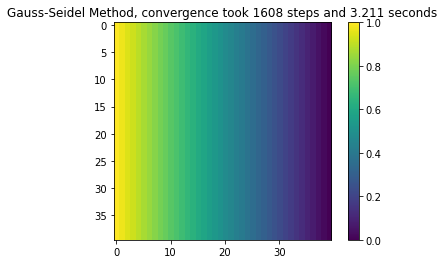

In [2]:
# Function to perform Gauss-Seidel method
# Input: V_0 = initial guess; V_solution = analytical solution; N = number of discrete points; tol = global error tolerance
# Outputs: Result potential; number of steps required for convergence; time required for convergence
def Gauss_Seidel(V_0, V_solution, N, tol):
    
    start_time = time.time() # Initial time to measure runtime
    steps = 1 # Counts number of iterations
    
    # Creates a variable for the 'new' array. 
    V = np.copy(V_0)
    
    # Makes the first Gauss-Seidel iteration, this is done outside the loop below to avoid the norm being zero
    for j in np.arange(1, N-1):
        # First row handled separately due to periodic BCs
        V[0, j] = (V[1, j] + V[N-1, j] + V[0, j+1] + V[0, j-1]) / 4.0
        
        # Second until second-to-last rows
        for i in np.arange(1, N-1):
            V[i, j] = (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0
        
        # Last row handled separately due to periodic BCs
        V[N-1, j] = (V[0, j] + V[N-2, j] + V[0, j+1] + V[0, j-1]) / 4.0
            
    # Main iteration loop. This will keep iterating until the norm reaches the desired tolerance
    while np.linalg.norm(V - V_solution) > tol:
        for j in np.arange(1, N-1):
            # First row handled separately due to periodic BCs
            V[0, j] = (V[1, j] + V[N-1, j] + V[0, j+1] + V[0, j-1]) / 4.0
            
            # Second until second-to-last rows
            for i in np.arange(1, N-1):
                V[i, j] = (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0
                
            # Last row handled separately due to periodic BCs
            V[N-1, j] = (V[0, j] + V[N-2, j] + V[0, j+1] + V[0, j-1]) / 4.0
        steps += 1
        
        # Prints every 300 steps in order to keep track of progress
        if steps%300 == 0:
            print('Iteration number %d, the error is %.2f' %(steps, np.linalg.norm(V - V_solution)))
          
    print ('Reaching a tolerance of %.1f took %.3f seconds and required %d steps.' %(tol, time.time() - start_time, steps))
    return V, steps, time.time() - start_time


# Calls the Gauss-Seidel function, and unpacks each returned variable into its own variable
GS, GSsteps, GStime = Gauss_Seidel(V_0, V_solution, N, tol)

# Plots result from GS method
plt.imshow(GS)
cb = plt.colorbar()
plt.title(r'Gauss-Seidel Method, convergence took %d steps and %.3f seconds' %(GSsteps, GStime))
plt.show()

-------------

Successive Over-Relaxation (SOR) metoden er igjen nesten helt identisk med Gauss-Seidel, forskjellen er at man innfører en *relaxation parameter*, $\omega \in (0, 2)$, og bruker denne til å generere en rekursjonsformel med et veid gjennomsnitt

\begin{equation}
V^{(\text{k}+1)}(x_i, y_j)= (1 - \omega)V^{(\text{k})}(x_i, y_j) +  \frac{\omega}{4}\big[ V^{(\text{k}+1)}(x_{i-1},y_j) + V^{(\text{k})}(x_{i+1},y_j) + V^{(\text{k}+1)}(x_i,y_{j-1}) + V^{(\text{k})}(x_i,y_{j+1})\big]\text{,}
\end{equation}

basert på valg av $\omega$ kan dette føre til drastisk forbedring i konvergenshastighet.

$\textbf{c)}$ For $i,j \in [0, 100]$, implementer SOR metoden på problemet ovenfor med forskjellige valg av $\omega$, og iterer til $\vert \vert V^{(\text{k}+1)}-V^{(\text{k})}\vert \vert < 10^{-4}$. Print antall steg og kjøretid, og plot potensialet som en heatmap.

Iteration number 100, the error is 6.41
Iteration number 200, the error is 2.49
Iteration number 300, the error is 0.97
Iteration number 400, the error is 0.38
Iteration number 500, the error is 0.15
Reaching a tolerance of 0.1 took 1.295 seconds and required 542 steps.


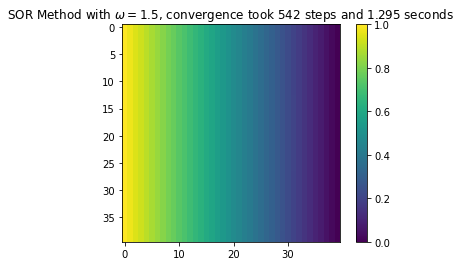

In [3]:
# Function to perform SOR method
# Input: V_0 = initial guess; V_solution = analytical solution; N = number of discrete points; 
# tol = global error tolerance; omega = relaxation parameter
# Outputs: Result potential; number of steps required for convergence; time required for convergence
def SOR(V_0, V_solution, N, tol, omega):
    
    start_time = time.time() # Initial time to measure runtime 
    steps = 1 # Counts number of iterations
    
    # Creates a variable for the 'new' array. 
    V = np.copy(V_0)
    
    # Makes the first SOR iteration, this is done outside the loop below to avoid the norm being zero
    for j in np.arange(1, N-1):
        # First row handled separately due to periodic BCs
        V[0, j] = (1.0-omega)*V[0,j] + omega*(V[1, j] + V[N-1, j] + V[0, j+1] + V[0, j-1]) / 4.0
        
        # Second until second-to-last rows
        for i in np.arange(1, N-1):
            V[i, j] = (1.0-omega)*V[i,j] + omega*(V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0
            
        # Last row handled separately due to periodic BCs      
        V[N-1, j] = (1.0-omega)*V[N-1,j] + omega*(V[0, j] + V[N-2, j] + V[0, j+1] + V[0, j-1]) / 4.0
            
    # Main iteration loop. This will keep iterating until the norm reaches the desired tolerance
    while np.linalg.norm(V - V_solution) > tol:
        for j in np.arange(1, N-1):
            
            # First row handled separately due to periodic BCs
            V[0, j] = (1.0-omega)*V[0,j] + omega*(V[1, j] + V[N-1, j] + V[0, j+1] + V[0, j-1]) / 4.0 
            
            # Second until second-to-last rows
            for i in np.arange(1, N-1): 
                V[i, j] = (1.0-omega)*V[i,j] + omega*(V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0
                
            # Last row handled separately due to periodic BCs  
            V[N-1, j] = (1.0-omega)*V[N-1,j] + omega*(V[0, j] + V[N-2, j] + V[0, j+1] + V[0, j-1]) / 4.0 # Last row
        steps += 1
        
        if steps%100 == 0:
            print('Iteration number %d, the error is %.2f' %(steps, np.linalg.norm(V - V_solution)))
          
    print ('Reaching a tolerance of %.1f took %.3f seconds and required %d steps.' %(tol, time.time() - start_time, steps))
    return V, steps, time.time() - start_time

# Relaxation parameter
omega = 1.5

# Calls the Gauss-Seidel function, and unpacks each returned variable into its own variable
Relax, Relaxsteps, Relaxtime = SOR(V_0, V_solution, N, tol, omega)

# Plots result from GS method
plt.imshow(Relax)
cb = plt.colorbar()
plt.title(r'SOR Method with $\omega = $%.1f, convergence took %d steps and %.3f seconds' %(omega, Relaxsteps, Relaxtime))
plt.show()

--------------------------

### Ekstraoppgave: Jacobi-Metoden med Array Operasjoner

Når du implementerte Jacobi-metoden over brukte du sannsynligvis en enkel $\texttt{while}$ løkke for å iterere på hvert element i arrayen (eller kanskje du brukte array-operasjoner og oppdaget at Gauss-Seidel og SOR konvergerte enten omtrent like raskt eller mye tregere enn Jacobi). Dette er på mange måter den *naive* måten å implementere det, men egentlig helt nødvendig for å implementere Gauss-Seidel og SOR siden disse metodene må gå gjennom elementene én om gangen. Som en konsekvens av dette er faktisk Jacobi implementert med array-operasjoner mye raskere enn både Gauss-Seidel og SOR. Generelt når du skal utføre større operasjoner i Python er det en stor fordel å unngå å gjøre beregninger i Python, og heller gjøre så mye som mulig internt i $\texttt{numpy}$ og $\texttt{scipy}$ funksjoner eller som array operasjoner. Selv om operasjonene som utføres kanskje er helt identiske, så vil de utføres mye raskere i $\texttt{numpy}$ og $\texttt{scipy}$ (dette er siden $\texttt{numpy}$ og $\texttt{scipy}$ bibliotekene er skrevet i FORTRAN og varianter av C, som er raskere språk enn Python). 

$\textbf{a)}$ Implementer Jacobi-metoden ved å bruke $\texttt{numpy}$ arrays, og kjør til $\vert \vert V^{(\text{k})}-V\vert \vert < 10^{-1}$. Print antall steg og kjøretid, og plot potensialet som en 3d-surface. *Hint:* En nyttig funksjon her er $\texttt{numpy.roll(V, shift, axis)}$, f.eks. vil $\texttt{numpy.roll(V, 1, 0)}$ skifte posisjonene på alle radene ett hakk ned med periodiske betingelser (dvs. rad nummer 1 blir til rad nummer 2, rad nummer $N$ blir rad nummer 0, osv.). 

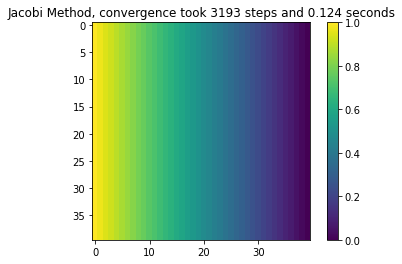

In [4]:
# Function to perform Jacobi method with arrays
# Input: V_0 = initial guess; V_solution = analytical solution; N = number of discrete points; tol = global error tolerance
# Outputs: Result potential; number of steps required for convergence; time required for convergence
def Clever_Jacobi(V_0, V_solution, N, tol):
    
    start_time = time.time() # Initial time to measure runtime 
    steps = 1   # Counts number of iterations
    
    # Creates a variable for the 'new' array
    V = np.copy(V_0)
    
    # Makes the first Jacobi iteration, this is done outside the loop below to avoid the norm being zero
    V[:,1:N-1] = (V[:,:N-2] + V[:,2:N]
        + np.roll(V[:,1:N-1],1,0) + np.roll(V[:,1:N-1],-1,0)) /4.0

    # Main iteration loop. This will keep iterating until the norm reaches the desired tolerance
    while np.linalg.norm(V - V_solution) > tol:
        V[:,1:N-1] = (V[:,:N-2] + V[:,2:N]
        + np.roll(V[:,1:N-1],1,0) + np.roll(V[:,1:N-1],-1,0)) /4.0
        steps += 1
          
    # Code runs so fast that this line is not really necessary
    # print ('Reaching a tolerance of %.1f took %.3f seconds and required %d steps.' %(tol, time.time() - start_time, steps))
    return V, steps, time.time() - start_time


# Calls the improved Jacobi-function, and unpacks each returned variable into its own variable
CleverJacob, CleverJacobsteps, CleverJacobtime = Clever_Jacobi(V_0, V_solution, N, tol)

# Plots result from Jacobi method
plt.imshow(CleverJacob)
cb = plt.colorbar()
plt.title(r'Jacobi Method, convergence took %d steps and %.3f seconds' %(CleverJacobsteps, CleverJacobtime))
plt.show()

$\textbf{b)}$ I stedet for at potensialet ved $x=0$ holdes konstant, så kan problemet modifiseres for hvilken som helst $L$-periodisk funksjon $V(0, y) = V_0(y)$ brukes. Kravet er da kun at $V_0(y=0) = V_0(y=L)$ (merk at dette vil føre til et diskontinuerlig elektrisk felt, for et fysisk system med periodiske grensebetingelser hvor vi også ser på det elektriske feltet trenger vi også at den første-deriverte til $V_0(y)$ også er $L$-periodisk). 

Implementer Jacobi-metoden som beskrevet over for forskjellige $L$-periodiske funksjoner, $V_0(y)$, f.eks. $V_0(y) = e^y sin( \pi y / L)$ eller $V_0(y) = sin(2 \pi y / L)cos(\pi y / L)$. Iterer til $\vert \vert V^{(\text{k}+1)}-V^{(\text{k})}\vert \vert < 10^{-5}$, og plot det resulterende potensialet som en 3d-overflate.

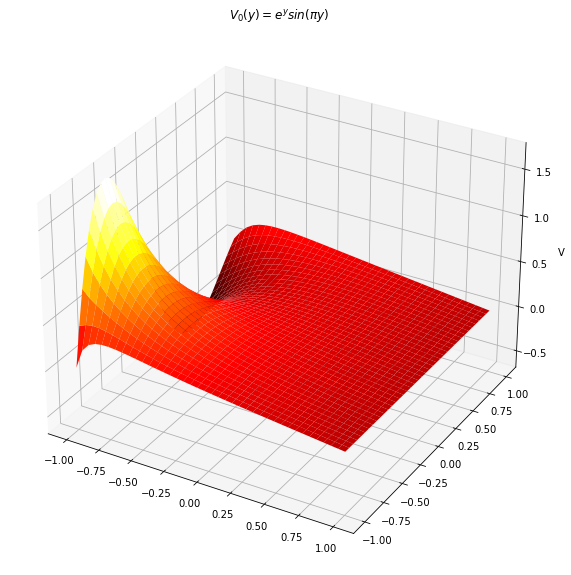

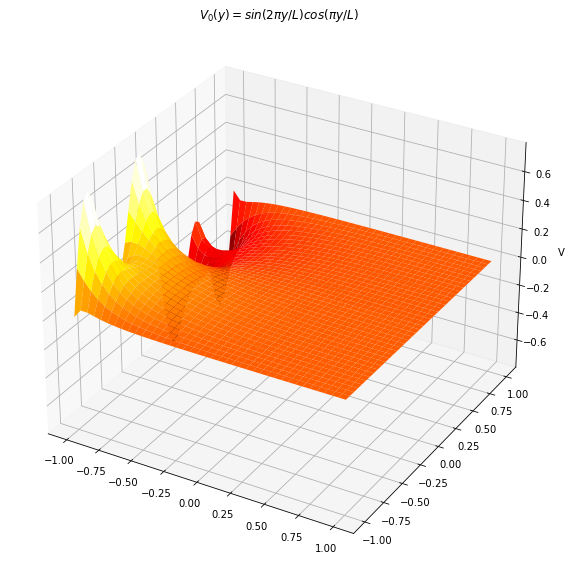

In [5]:
local_tol = 1e-5 # Tolerance for the local truncation error

# Function to perform Jacobi method
# Input: V_0 = initial guess; V_solution = analytical solution; N = number of discrete points; tol = global error tolerance
# Outputs: Result potential; number of steps required for convergence; time required for convergence
def Cleverer_Jacobi(V_0, N, tol):
    
    V_old = V_0 # Creates variable for the 'old' array
    
    # Creates a variable for the 'new' array
    V = np.copy(V_0)
    
    # Makes the first Jacobi iteration, this is done outside the loop below to avoid the norm being zero
    V[:,1:N-1] = (V[:,:N-2] + V[:,2:N]
        + np.roll(V[:,1:N-1],1,0) + np.roll(V[:,1:N-1],-1,0)) /4.0

    # Main iteration loop. This will keep iterating until the norm reaches the desired tolerance
    while np.linalg.norm(V - V_old) > tol:
        V_old = np.copy(V)
        V[:,1:N-1] = (V[:,:N-2] + V[:,2:N]
        + np.roll(V[:,1:N-1],1,0) + np.roll(V[:,1:N-1],-1,0)) /4.0
        
    return V




# First example, V_0(y) = e^y * sin(pi * y)
V_exp = np.zeros((N,N)) 
V_exp[:,0] = np.exp(y)*np.sin(np.pi*y)

V_exp = Cleverer_Jacobi(V_exp, N, local_tol)

plt.rcParams['figure.figsize'] = [15, 10] # Makes the figures bigger in Jupyter
from mpl_toolkits.mplot3d import Axes3D # Library for 3d-plots

# Plot the array elements of V as a 3d surface, this one is more tricky as you need to make a
# figure-like object, declare that it's for 3d-plotting, and only then can we create the 3d surface plot

fig = plt.figure() # Creates a figure object

ax = fig.gca(projection='3d') # Creates a 3d projection in the figure

surf = ax.plot_surface(xv, yv,      # x- and y-axes
                       V_exp,           # z-values
                       cmap='hot')  # Colour choice

ax.set_title(r'$V_0(y) = e^ysin(\pi y)$')
ax.set_zlabel('V')

plt.show()



# Second example, V_0(y) = cos(pi * y) * sin(2pi * y)

V_periodic = np.zeros((N,N))
V_periodic[:,0] = np.cos(np.pi*y)*np.sin(2*np.pi*y)

V_periodic = Cleverer_Jacobi(V_periodic, N, local_tol)

fig = plt.figure() # Creates a figure object

ax = fig.gca(projection='3d') # Creates a 3d projection in the figure

surf = ax.plot_surface(xv, yv,      # x- and y-axes
                       V_periodic,           # z-values
                       cmap='hot')  # Colour choice

ax.set_title(r'$V_0(y) = sin(2 \pi y / L)cos(\pi y / L)$')
ax.set_zlabel('V')

plt.show()